In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


In [2]:
import os
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

2024-07-24 04:15:46.116037: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 04:15:46.116153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 04:15:46.403740: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_path = "/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip"
test_path = "/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip"

files = "/kaggle/working/"

import zipfile

with zipfile.ZipFile(train_path, 'r') as zipp:
    zipp.extractall(files)
    
with zipfile.ZipFile(test_path, 'r') as zipp:
    zipp.extractall(files)

In [4]:
image_dir = "../working/train/"

filenames = os.listdir(image_dir)

labels = [x.split(".")[0] for x in filenames]

data = pd.DataFrame({"filename": filenames, "label": labels})

data.head()

,filename,label
0,dog.6746.jpg,dog
1,dog.9805.jpg,dog
2,dog.8404.jpg,dog
3,cat.12371.jpg,cat
4,cat.10021.jpg,cat


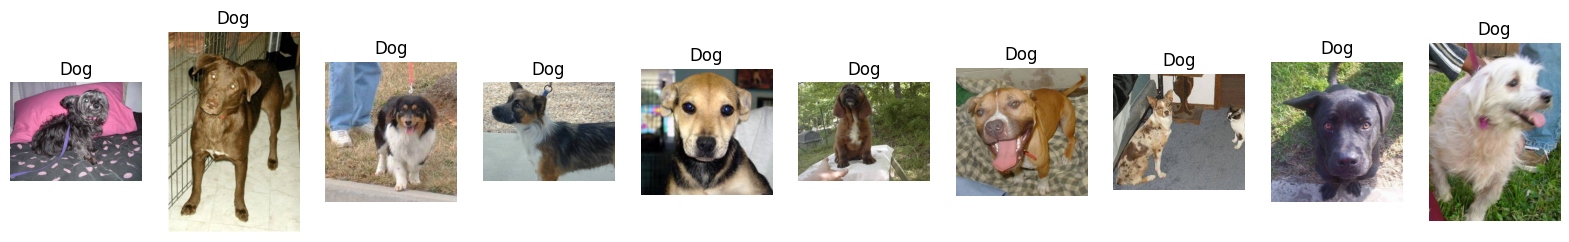

In [5]:

plt.figure(figsize=(20,20))

plt.subplots_adjust(hspace=0.4)

for i in range(10):
    
    plt.subplot(1,10,i+1)
    filename = 'train/' + 'dog.' + str(i) + '.jpg'
    image = imread(filename)
    
    plt.imshow(image)
    plt.title('Dog',fontsize=12)
    plt.axis('off')

plt.show()

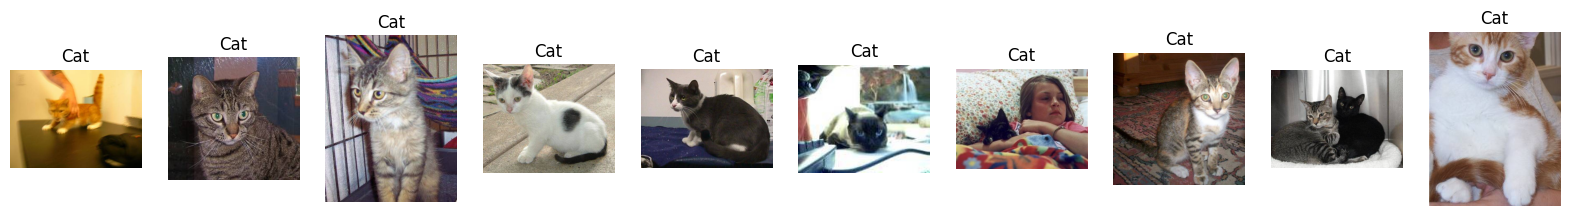

In [6]:

plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.4)

for i in range(10):
    
    plt.subplot(1,10,i+1)
    filename = 'train/' + 'cat.' + str(i) + '.jpg'
    image = imread(filename)
    plt.imshow(image)
    plt.title('Cat',fontsize=12)
    plt.axis('off')

plt.show()

In [7]:

labels = data['label']

X_train, X_temp = train_test_split(data, test_size=0.2, stratify=labels, random_state = 42)

label_test_val = X_temp['label']

X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)

The shape of train data (20000, 2)
The shape of test data (2500, 2)
The shape of validation data (2500, 2)


In [9]:

image_size = 128
image_channel = 3
bat_size = 32

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.1,
    fill_mode='reflect',
    width_shift_range=0.1,
    height_shift_range=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)


In [11]:

train_generator = train_datagen.flow_from_dataframe(X_train,
                                                    directory = 'train/',
                                                    x_col= 'filename',
                                                    y_col= 'label',
                                                    batch_size = bat_size,
                                                    target_size = (image_size,image_size)
                                                   )

val_generator = test_datagen.flow_from_dataframe(X_val, 
                                                 directory = 'train/',
                                                 x_col= 'filename',
                                                 y_col= 'label',
                                                 batch_size = bat_size,
                                                 target_size = (image_size,image_size),
                                                 shuffle=False
                                                )

test_generator = test_datagen.flow_from_dataframe(X_test, 
                                                  directory = 'train/',
                                                  x_col= 'filename',
                                                  y_col= 'label',
                                                  batch_size = bat_size,
                                                  target_size = (image_size,image_size),
                                                  shuffle=False
                                                 )

Found 20000 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


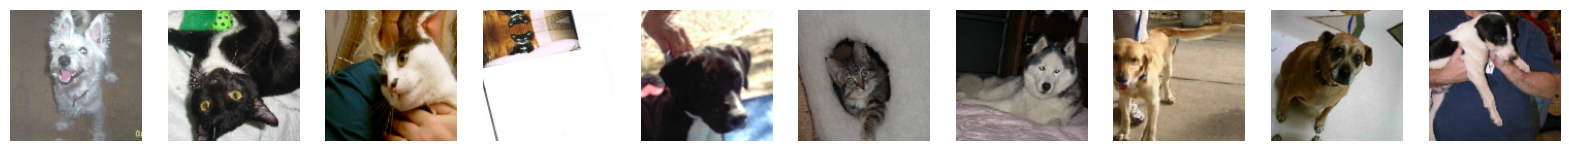

In [12]:
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.4)

datagen_iter = train_generator

for i in range(10):
    plt.subplot(1, 10, i + 1)
    batch = next(datagen_iter)
    image = batch[0][0]
    plt.imshow(image)
    plt.axis('off')
    
plt.show()


In [13]:
model = Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape = (image_size,image_size,image_channel))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(2,activation='softmax'))

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,112,514 (19.50 MB)

 Trainable params: 5,110,530 (19.50 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [14]:

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2, 
                                            factor=0.5, 
                                            min_lr = 0.00001, 
                                            verbose = 1) 

early_stoping = EarlyStopping(monitor='val_loss',patience= 3,restore_best_weights=True,verbose=0)

In [15]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [16]:

cat_dog = model.fit(train_generator,
                    validation_data = val_generator, 
                    callbacks=[early_stoping,learning_rate_reduction],
                    epochs = 30,
                   )

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/625 ━━━━━━━━━━━━━━━━━━━━ 3:18:57 19s/step - accuracy: 0.6250 - loss: 0.7504

I0000 00:00:1721795120.595334      90 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721795120.618138      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.6281 - loss: 0.7643

W0000 00:00:1721795213.975356      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


625/625 ━━━━━━━━━━━━━━━━━━━━ 117s 157ms/step - accuracy: 0.6282 - loss: 0.7639 - val_accuracy: 0.7052 - val_loss: 0.5614 - learning_rate: 0.0010
Epoch 2/30


W0000 00:00:1721795218.258589      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


625/625 ━━━━━━━━━━━━━━━━━━━━ 96s 152ms/step - accuracy: 0.7390 - loss: 0.5336 - val_accuracy: 0.7768 - val_loss: 0.4854 - learning_rate: 0.0010
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 96s 152ms/step - accuracy: 0.7947 - loss: 0.4487 - val_accuracy: 0.8148 - val_loss: 0.4315 - learning_rate: 0.0010
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 98s 155ms/step - accuracy: 0.8218 - loss: 0.3904 - val_accuracy: 0.8348 - val_loss: 0.3704 - learning_rate: 0.0010
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 96s 152ms/step - accuracy: 0.8453 - loss: 0.3450 - val_accuracy: 0.8280 - val_loss: 0.3643 - learning_rate: 0.0010
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 151ms/step - accuracy: 0.8559 - loss: 0.3262 - val_accuracy: 0.8464 - val_loss: 0.3779 - learning_rate: 0.0010
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 96s 153ms/step - accuracy: 0.8751 - loss: 0.2929 - val_accuracy: 0.8392 - val_loss: 0.3495 - learning_rate: 0.0010
Epoch 8/30
624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8848 - loss:

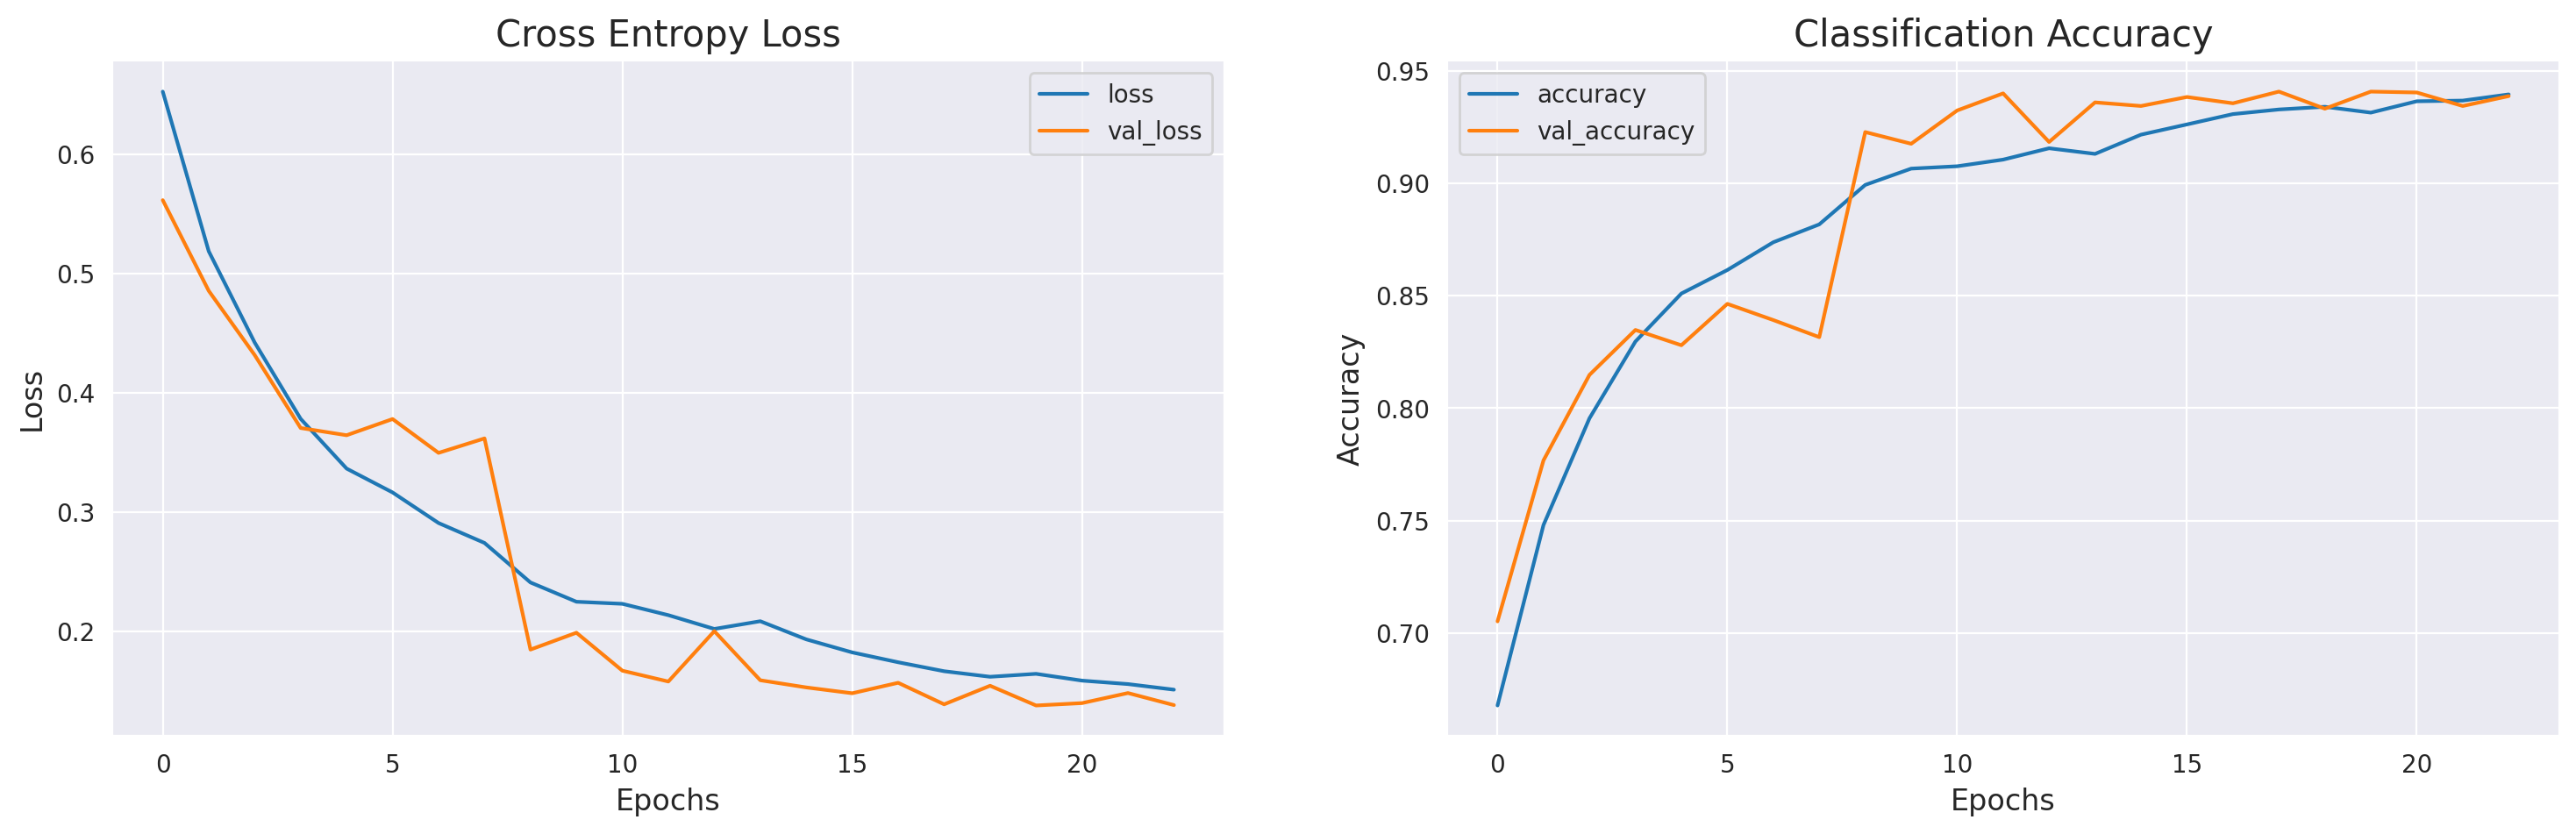

In [17]:
error = pd.DataFrame(cat_dog.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'], label='loss')
plt.plot(error['val_loss'], label='val_loss')
plt.legend()

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'], label='accuracy')
plt.plot(error['val_accuracy'], label='val_accuracy')
plt.legend()

plt.show()

In [18]:
loss,acc = model.evaluate(train_generator,batch_size = bat_size, verbose = 0)
print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)
loss,acc = model.evaluate(val_generator,batch_size = bat_size, verbose = 0)
print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

The accuracy of the model for training data is: 95.60499787330627
The Loss of the model for training data is: 0.11404338479042053
The accuracy of the model for validation data is: 94.08000111579895
The Loss of the model for validation data is: 0.13779500126838684


In [19]:
model.save("model.h5")

In [20]:
result = model.predict(test_generator,batch_size = bat_size,verbose = 0)
y_pred = np.argmax(result, axis = 1)
y_true = test_generator.labels
loss,acc = model.evaluate(test_generator, batch_size = bat_size, verbose = 0)
print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

W0000 00:00:1721797911.555805      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721797915.452788      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


The accuracy of the model for testing data is: 94.88000273704529
The Loss of the model for testing data is: 0.12928174436092377


In [21]:
labels =['Cat','Dog']
print(classification_report(y_true, y_pred,target_names=labels))

              precision    recall  f1-score   support

         Cat       0.95      0.95      0.95      1250
         Dog       0.95      0.95      0.95      1250

    accuracy                           0.95      2500
   macro avg       0.95      0.95      0.95      2500
weighted avg       0.95      0.95      0.95      2500



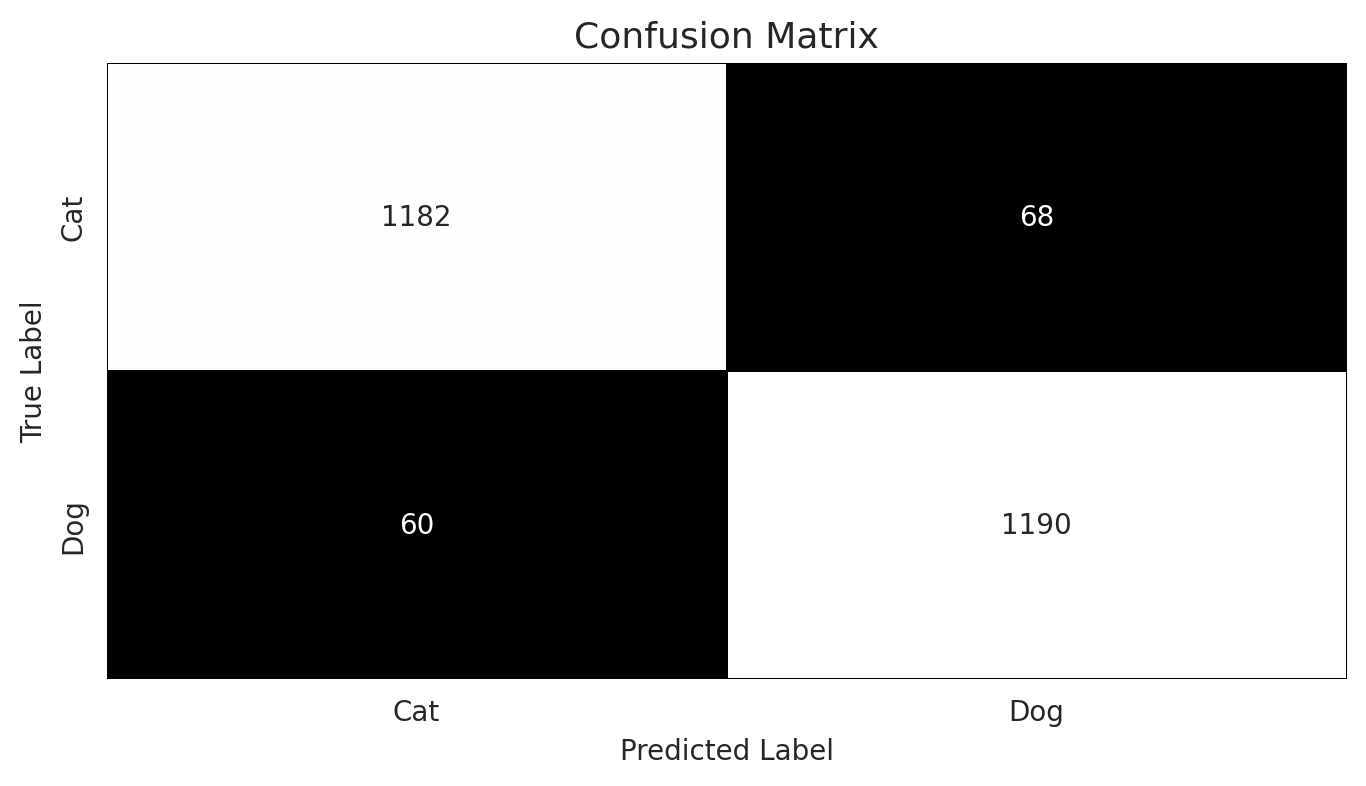

In [22]:
confusion_mtx = confusion_matrix(y_true,y_pred) 
f,ax = plt.subplots(figsize = (8,4),dpi=200)
sns.heatmap(confusion_mtx, annot=True, linewidths=0.1, cmap = "gist_yarg_r", linecolor="black", fmt='.0f', ax=ax,cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label",fontsize=10)
plt.ylabel("True Label",fontsize=10)
plt.title("Confusion Matrix",fontsize=13)

plt.show()

In [23]:
size =(128,128)
test_dir = "../working/test/"
filenames = os.listdir(test_dir)
test_data = pd.DataFrame({"filename": filenames})
test_data['label'] = 'unknown'
test_idg =  test_datagen.flow_from_dataframe(test_data, 
                                     "test/", 
                                     x_col= "filename",
                                     y_col = 'label',
                                     batch_size = bat_size,
                                     target_size=size, 
                                     shuffle = False)

test_predict = model.predict(test_idg,verbose = 0)

test_predict_argmax = np.argmax(test_predict, axis=1)

y_test_pred = test_predict_argmax

test_data['label'] = y_test_pred

label_mapping = {0: 'cat', 1: 'dog'}
test_data['label'] = test_data['label'].map(label_mapping)
test_data.head()

sub = pd.read_csv('/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv',index_col='id')

sub['label'] = y_test_pred

sub.to_csv('submission.csv',index=True)

Found 12500 validated image filenames belonging to 1 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
W0000 00:00:1721797932.653726      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1721797950.397517      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


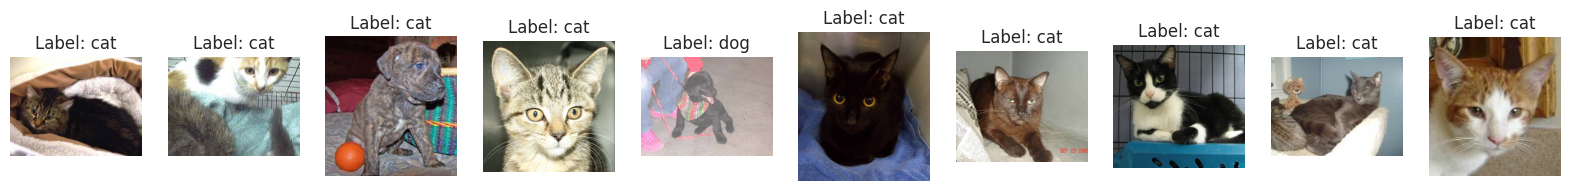

In [24]:
fig, axes = plt.subplots(1, 10, figsize=(20, 4))
for idx in range(10):
    image_path = os.path.join(test_dir, test_data.iloc[idx]['filename'])
    image = Image.open(image_path)
    axes[idx].imshow(image)
    axes[idx].set_title("Label: " + test_data.iloc[idx]['label'])
    axes[idx].axis('off')
plt.show()